In [12]:
import tensorflow as tf
import numpy as np
#import mnist_handler
import os
import pandas as pd
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"; 
INPUT_DIMENSION = 7129
NUM_CLASSES = 6

train_dataset = np.array(pd.read_csv("UCI dataset/duke", header = None,delimiter=' '))
print(train_dataset.shape)
label = train_dataset[:,0]
data = train_dataset[:,2:]
label = label.reshape(label.shape[0], 1)

data1 = []
for i in data:
    data2 = []
    for j in i:
        [_, value] = j.split(":")
        data2.append(value)
    data1.append(data2)
    
data = np.array(data1)
data = np.array(data1)
print(data)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)
print(data)

label1 = np.where(label==-1, 0, label)
label1 = np.where(label1==1.0, 1, label1)
#print(label1)
data2 = np.concatenate((label1, data), axis = 1)

p = np.random.permutation(len(data2))
data2 = data2[p]
x_train = data2[0:29,1:]
y_train = data2[0:29,0]
x_test = data2[29:,1:]
y_test = data2[29:,0]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(44, 7131)
[['-0.362772' '-0.314085' '-0.177185' ... '0.343084' '-1.243480'
  '1.804020']
 ['-0.459580' '-0.719855' '-1.005840' ... '-0.729734' '-0.639368'
  '0.344724']
 ['0.103909' '-0.296076' '-0.165474' ... '0.181200' '-0.626812'
  '0.237308']
 ...
 ['-0.512385' '-0.326583' '-0.091035' ... '0.180162' '0.701266'
  '-0.305400']
 ['-0.213418' '0.415821' '-0.361252' ... '1.001600' '-0.390027'
  '-0.624770']
 ['-0.724510' '-0.359479' '-0.847507' ... '0.222557' '-0.733495'
  '-0.821411']]
[[0.12875974 0.25393584 0.24650594 ... 0.53694991 0.17216095 0.88753505]
 [0.11473679 0.18010967 0.0178938  ... 0.31134664 0.30510462 0.54421007]
 [0.19635998 0.25721241 0.24973681 ... 0.50290726 0.30786775 0.51893857]
 ...
 [0.10708781 0.25166194 0.27027329 ... 0.50268898 0.60013072 0.39125699]
 [0.15039415 0.3867356  0.19572491 ... 0.67542947 0.35997575 0.31611959]
 [0.07636082 0.24567681 0.06157524 ... 0.51160424 0.2843906  0.26985635]]


/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype <U9 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(29, 7129)
(15, 7129)
(29,)
(15,)


In [13]:

border = 11
x_train_init = x_train[:border]
y_train_init = y_train[:border]
x_train_seq = x_train[border:]
y_train_seq = y_train[border:]


In [14]:
x_train_init.shape,x_train_seq.shape

((11, 7129), (18, 7129))

In [15]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(-1))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [16]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [17]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

# Initial Training

In [18]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init



In [19]:
beta_1_init

<tf.Tensor 'Assign_3:0' shape=(6, 6) dtype=float32_ref>

In [20]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [21]:

'''With one subnetwork'''
logits_init = subnet_output(alpha_1, beta_1, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [22]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

ResourceExhaustedError: OOM when allocating tensor with shape[7129,7129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node k/Initializer/random_uniform/RandomUniform (defined at <ipython-input-16-c1d777e3ab1f>:1)  = RandomUniform[T=DT_INT32, _class=["loc:@k/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](k/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'k/Initializer/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/lib/python3/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/lib/python3/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/lib/python3/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/lib/python3/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-c1d777e3ab1f>", line 1, in <module>
    k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 1487, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 1237, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 540, in get_variable
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 492, in _true_getter
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 922, in _get_single_variable
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 183, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 146, in _variable_v1_call
    aggregation=aggregation)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 125, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 2444, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 187, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 1329, in __init__
    constraint=constraint)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variables.py", line 1437, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/variable_scope.py", line 896, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/init_ops.py", line 255, in __call__
    shape, self.minval, self.maxval, dtype, seed=self.seed)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/random_ops.py", line 243, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/lib/python3/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 733, in random_uniform
    name=name)
  File "/usr/lib/python3/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/lib/python3/dist-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/lib/python3/dist-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/lib/python3/dist-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[7129,7129] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node k/Initializer/random_uniform/RandomUniform (defined at <ipython-input-16-c1d777e3ab1f>:1)  = RandomUniform[T=DT_INT32, _class=["loc:@k/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](k/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
"""Initial training"""

sess.run(E_1_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

In [ ]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [ ]:
"""Initial training"""
s  =0
t1 = time.time()
sess.run(E_2_init, feed_dict={X_: x_train_init, Y: y_train_init})
t2 = time.time()
s+=(t2-t1)
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

In [ ]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [ ]:
"""Initial training"""
import time
t1 = time.time()
s = 0
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
t2 = time.time()
s+= t2 -t1
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)
print(s)

# Sequential Training

In [18]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq




In [14]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [15]:
"""Sequential training"""
batch_size = 9

epoch_train_accuracy = []
epoch_test_accuracy = []
t1 = time.time()
for epoch in range(100):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
t2 = time.time()
s+=t2-t1
print("Sequential training done")
print(s)

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)

train_loss: 0.025626, train_accuracy: 1.000000
test_loss: 0.095337, test_accuracy: 0.600000
train_loss: 0.027915, train_accuracy: 1.000000
test_loss: 0.097253, test_accuracy: 0.600000
train_loss: 0.029965, train_accuracy: 1.000000
test_loss: 0.098664, test_accuracy: 0.600000
train_loss: 0.031021, train_accuracy: 1.000000
test_loss: 0.099488, test_accuracy: 0.600000
train_loss: 0.031532, train_accuracy: 1.000000
test_loss: 0.099952, test_accuracy: 0.666667
train_loss: 0.031766, train_accuracy: 1.000000
test_loss: 0.100194, test_accuracy: 0.666667
train_loss: 0.031861, train_accuracy: 1.000000
test_loss: 0.100297, test_accuracy: 0.666667
train_loss: 0.031883, train_accuracy: 1.000000
test_loss: 0.100312, test_accuracy: 0.666667
train_loss: 0.031868, train_accuracy: 1.000000
test_loss: 0.100271, test_accuracy: 0.666667
train_loss: 0.031834, train_accuracy: 1.000000
test_loss: 0.100193, test_accuracy: 0.666667
train_loss: 0.031790, train_accuracy: 1.000000
test_loss: 0.100093, test_accurac

train_loss: 0.029852, train_accuracy: 1.000000
test_loss: 0.093017, test_accuracy: 0.600000
train_loss: 0.029844, train_accuracy: 1.000000
test_loss: 0.092963, test_accuracy: 0.600000
train_loss: 0.029836, train_accuracy: 1.000000
test_loss: 0.092909, test_accuracy: 0.600000
train_loss: 0.029828, train_accuracy: 1.000000
test_loss: 0.092855, test_accuracy: 0.600000
train_loss: 0.029821, train_accuracy: 1.000000
test_loss: 0.092803, test_accuracy: 0.600000
train_loss: 0.029813, train_accuracy: 1.000000
test_loss: 0.092750, test_accuracy: 0.600000
train_loss: 0.029806, train_accuracy: 1.000000
test_loss: 0.092699, test_accuracy: 0.600000
train_loss: 0.029799, train_accuracy: 1.000000
test_loss: 0.092648, test_accuracy: 0.600000
train_loss: 0.029792, train_accuracy: 1.000000
test_loss: 0.092597, test_accuracy: 0.600000
train_loss: 0.029786, train_accuracy: 1.000000
test_loss: 0.092547, test_accuracy: 0.600000
Sequential training done
70.9501256942749


'Sequential training evaluation'

In [19]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
"""Sequential training"""
batch_size = 6

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(50):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X_: x_batch, Y: y_batch})
    t2 = time.time()
    s+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")
time_sum = time_sum
"""Sequential training evaluation"""

train_loss: 0.037375, train_accuracy: 0.931035
test_loss: 0.104861, test_accuracy: 0.400000
train_loss: 0.031794, train_accuracy: 1.000000
test_loss: 0.101827, test_accuracy: 0.533333
train_loss: 0.031925, train_accuracy: 1.000000
test_loss: 0.102039, test_accuracy: 0.533333
train_loss: 0.032740, train_accuracy: 1.000000
test_loss: 0.102562, test_accuracy: 0.533333
train_loss: 0.033442, train_accuracy: 1.000000
test_loss: 0.103038, test_accuracy: 0.533333
train_loss: 0.033945, train_accuracy: 1.000000
test_loss: 0.103417, test_accuracy: 0.533333
train_loss: 0.034284, train_accuracy: 1.000000
test_loss: 0.103705, test_accuracy: 0.533333
train_loss: 0.034504, train_accuracy: 1.000000
test_loss: 0.103917, test_accuracy: 0.533333
train_loss: 0.034643, train_accuracy: 1.000000
test_loss: 0.104066, test_accuracy: 0.533333
train_loss: 0.034727, train_accuracy: 1.000000
test_loss: 0.104166, test_accuracy: 0.533333
train_loss: 0.034775, train_accuracy: 1.000000
test_loss: 0.104226, test_accurac

NameError: name 'time_sum' is not defined

In [26]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [21]:
s/50

0.7987442111968994

In [27]:
time_sum

1.20870840549469

In [28]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [29]:
"""Sequential training"""
batch_size = 6

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.158726, train_accuracy: 0.448276
test_loss: 0.227396, test_accuracy: 0.266667
train_loss: 0.124700, train_accuracy: 0.655172
test_loss: 0.291086, test_accuracy: 0.200000
train_loss: 0.113931, train_accuracy: 0.655172
test_loss: 0.286599, test_accuracy: 0.266667
train_loss: 0.110388, train_accuracy: 0.793103
test_loss: 0.280894, test_accuracy: 0.266667
train_loss: 0.108524, train_accuracy: 0.793103
test_loss: 0.276200, test_accuracy: 0.333333
train_loss: 0.107338, train_accuracy: 0.793103
test_loss: 0.271405, test_accuracy: 0.333333
train_loss: 0.106554, train_accuracy: 0.793103
test_loss: 0.266130, test_accuracy: 0.333333
train_loss: 0.106049, train_accuracy: 0.758621
test_loss: 0.260597, test_accuracy: 0.333333
train_loss: 0.105737, train_accuracy: 0.758621
test_loss: 0.255146, test_accuracy: 0.333333
train_loss: 0.105549, train_accuracy: 0.758621
test_loss: 0.250038, test_accuracy: 0.400000
Sequential training done


'Sequential training evaluation'

In [30]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X: [x_test[4000]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[4000])
plt.imshow(x_test[4000])

NameError: name 'X' is not defined

In [ ]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 28)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 28)
visualize_beta(beta_2)

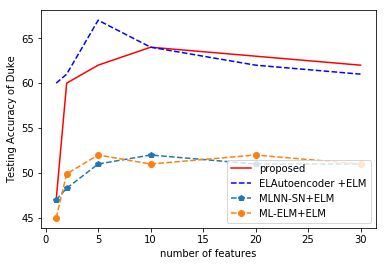

In [3]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
x = [1,2,5,10,20,30]
y1 = [47,60,62,64,63,62]
y2 = [60,61,67,64,62,61]
y3 = [47,48.3,51,52,51,51]
y4 = [45,49.9,52,51,52,51]

plt.plot(x,y1,'-r')
plt.plot(x,y2,'--b')
plt.plot(x,y3,'--p')
plt.plot(x,y4,'--o')
plt.ylabel('Testing Accuracy of Duke')
plt.xlabel('number of features')
plt.legend(['proposed', 'ELAutoencoder +ELM','MLNN-SN+ELM','ML-ELM+ELM'], loc='lower right')



In [ ]:
sess.run(tf.math.sin(tf.constant([0.9])))